In [1]:
"""
training generator should be not training discirmatier but i train i will fix someday
"""


import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt

# Read the dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:

def discriminator(images, reuse_variables=None,trainable = True):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4
        """
        if(trainable = False):
            tvars = tf.trainable_variables()
            d_vars = [var for var in tvars if 'd_' in var.name]
            
        """
        # d4 contains unscaled values
        return d4

In [3]:
def generator(z, batch_size, z_dim,trainable = True):
    # From z_dim to 56*56 dimension
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    """
    if(trainable = False):
        tvars = tf.trainable_variables()
        d_vars = [var for var in tvars if 'd_' in var.name]    
    """

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

In [4]:
batch_size = 32
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

In [5]:
# Two Loss Functions for discriminator
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

# Loss function for generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))

In [6]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [9]:
""" Start Training Session """

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
steps = 100000
Rresults = []
Fresults = []
# Pre-train discriminator
for i in range(steps):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})
    Rresults.append(dLossReal)
    Fresults.append(dLossFake)
    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)


dLossReal: 0.6937751 dLossFake: 0.6931163
dLossReal: 0.010224308 dLossFake: 0.08143554
dLossReal: 0.00021810981 dLossFake: 0.00060868735
dLossReal: 1.0424873e-07 dLossFake: 0.0003617672
dLossReal: 4.289567e-08 dLossFake: 1.6397526e-05
dLossReal: 1.9222115e-07 dLossFake: 2.3810815e-05
dLossReal: 6.329153e-05 dLossFake: 4.4375706e-06
dLossReal: 1.8373952e-06 dLossFake: 0.00018697235
dLossReal: 2.8638267e-06 dLossFake: 7.9756726e-05
dLossReal: 2.1560287e-07 dLossFake: 3.28591e-05
dLossReal: 3.1958444e-07 dLossFake: 3.629765e-05
dLossReal: 1.7382375e-06 dLossFake: 3.5197e-05
dLossReal: 5.0438207e-08 dLossFake: 2.1518545e-05
dLossReal: 9.633332e-09 dLossFake: 1.7425513e-05
dLossReal: 2.7108103e-07 dLossFake: 3.7422592e-06
dLossReal: 1.7525589e-07 dLossFake: 9.3032855e-07
dLossReal: 8.6868746e-10 dLossFake: 8.1083056e-07
dLossReal: 1.7020795e-07 dLossFake: 1.0140683e-06
dLossReal: 1.5155283e-11 dLossFake: 1.3751758e-06
dLossReal: 2.9999444e-07 dLossFake: 1.1605507e-06
dLossReal: 2.3746252e-0

dLossReal: 0.12267752 dLossFake: 0.015951727
dLossReal: 0.0069435947 dLossFake: 0.015999615
dLossReal: 1.2518337e-06 dLossFake: 0.0013111106
dLossReal: 3.7300896e-07 dLossFake: 0.0018889891
dLossReal: 9.21623e-05 dLossFake: 0.00041305702
dLossReal: 0.2388016 dLossFake: 0.00034860545
dLossReal: 1.0703166e-12 dLossFake: 0.0030250233
dLossReal: 1.3379238e-06 dLossFake: 2.048245e-05
dLossReal: 0.00013814493 dLossFake: 2.269221e-05
dLossReal: 4.8929806e-08 dLossFake: 0.0001949271
dLossReal: 1.4980767e-06 dLossFake: 0.00046155945
dLossReal: 3.8341655e-05 dLossFake: 2.1364027e-05
dLossReal: 6.766476e-08 dLossFake: 6.169914e-05
dLossReal: 1.1888783e-11 dLossFake: 0.0035047936
dLossReal: 5.2171526e-07 dLossFake: 1.711696e-05
dLossReal: 4.7998095e-05 dLossFake: 0.00023054941
dLossReal: 1.6005918e-06 dLossFake: 4.928561e-06
dLossReal: 1.0895058e-06 dLossFake: 0.00016168214
dLossReal: 1.5874642e-11 dLossFake: 0.0013276538
dLossReal: 3.4095772e-06 dLossFake: 1.0583234e-05
dLossReal: 1.0778741e-14 d

dLossReal: 8.4069095e-18 dLossFake: 4.0585287e-13
dLossReal: 4.0976666e-24 dLossFake: 3.4530328e-14
dLossReal: 6.9775177e-19 dLossFake: 7.380775e-08
dLossReal: 2.080533e-19 dLossFake: 3.2991353e-12
dLossReal: 6.6932127e-28 dLossFake: 1.322864e-12
dLossReal: 1.5497287e-18 dLossFake: 2.8309394e-13
dLossReal: 1.4511879e-22 dLossFake: 8.885397e-14
dLossReal: 2.1663367e-21 dLossFake: 5.065597e-12
dLossReal: 1.5406779e-16 dLossFake: 2.4459094e-12
dLossReal: 1.9562708e-21 dLossFake: 1.429902e-12
dLossReal: 4.070484e-18 dLossFake: 3.7093488e-11
dLossReal: 8.332712e-23 dLossFake: 8.514888e-12
dLossReal: 2.3897716e-19 dLossFake: 8.2828763e-13
dLossReal: 0.0 dLossFake: 3.01726e-11
dLossReal: 1.3822068e-18 dLossFake: 2.8849426e-11
dLossReal: 1.05687185e-22 dLossFake: 4.3919298e-13
dLossReal: 6.891535e-24 dLossFake: 5.3292742e-11
dLossReal: 2.6483432e-18 dLossFake: 5.8084176e-11
dLossReal: 5.4442903e-19 dLossFake: 2.9461853e-11
dLossReal: 1.5588589e-27 dLossFake: 1.1182408e-11
dLossReal: 1.8487892e

dLossReal: 0.0 dLossFake: 2.219328e-23
dLossReal: 2.049366e-21 dLossFake: 7.281843e-21
dLossReal: 3.59665e-24 dLossFake: 1.3505624e-22
dLossReal: 2.0440236e-23 dLossFake: 2.0975249e-22
dLossReal: 3.8021412e-22 dLossFake: 5.1835e-23
dLossReal: 4.1206218e-16 dLossFake: 2.4594306e-17
dLossReal: 1.1566515e-16 dLossFake: 7.824291e-21
dLossReal: 7.8662227e-20 dLossFake: 3.561128e-21
dLossReal: 5.6572368e-30 dLossFake: 8.627315e-17
dLossReal: 0.0 dLossFake: 8.70521e-22
dLossReal: 7.180832e-16 dLossFake: 6.8323606e-20
dLossReal: 7.5869086e-32 dLossFake: 1.0782487e-21
dLossReal: 2.4910528e-26 dLossFake: 3.1478948e-22
dLossReal: 3.0085035e-15 dLossFake: 4.8012083e-21
dLossReal: 1.4498465e-19 dLossFake: 2.7041312e-19
dLossReal: 3.303604e-24 dLossFake: 3.631717e-21
dLossReal: 1.5571643e-21 dLossFake: 2.6519503e-21
dLossReal: 5.6485074e-17 dLossFake: 6.7629033e-22
dLossReal: 1.0222924e-21 dLossFake: 1.12345005e-20
dLossReal: 7.6771773e-16 dLossFake: 3.375182e-19
dLossReal: 2.7938505e-22 dLossFake: 

dLossReal: 1.2675375e-23 dLossFake: 8.1116255e-21
dLossReal: 5.6977737e-25 dLossFake: 3.7556358e-22
dLossReal: 1.9429781e-25 dLossFake: 5.9884294e-21
dLossReal: 3.008367e-21 dLossFake: 1.6995435e-21
dLossReal: 4.126717e-26 dLossFake: 1.1282177e-20
dLossReal: 2.0868132e-16 dLossFake: 1.3932502e-21
dLossReal: 0.0 dLossFake: 4.4232465e-21
dLossReal: 6.3305096e-31 dLossFake: 1.0428425e-20
dLossReal: 1.6333232e-19 dLossFake: 1.0493292e-21
dLossReal: 2.6723474e-23 dLossFake: 1.6721579e-21
dLossReal: 3.4426043e-18 dLossFake: 1.3622707e-20
dLossReal: 3.604167e-18 dLossFake: 7.0231164e-21
dLossReal: 1.9306386e-26 dLossFake: 1.0042418e-19
dLossReal: 0.0 dLossFake: 2.7464798e-21
dLossReal: 5.4233195e-31 dLossFake: 1.6497597e-21
dLossReal: 1.6021351e-27 dLossFake: 9.743096e-21
dLossReal: 1.2972321e-24 dLossFake: 1.9318468e-18
dLossReal: 1.724523e-19 dLossFake: 8.670208e-21
dLossReal: 5.097616e-21 dLossFake: 6.8687126e-20
dLossReal: 5.29365e-23 dLossFake: 3.070547e-21
dLossReal: 3.632981e-21 dLossF

dLossReal: 7.648974e-27 dLossFake: 1.8242189e-19
dLossReal: 9.882797e-22 dLossFake: 1.1806462e-20
dLossReal: 5.8282235e-24 dLossFake: 4.5124796e-20
dLossReal: 3.13634e-21 dLossFake: 8.419674e-21
dLossReal: 8.390668e-25 dLossFake: 4.758493e-21
dLossReal: 1.9580577e-20 dLossFake: 1.1578131e-20
dLossReal: 4.4440583e-19 dLossFake: 6.7560985e-20
dLossReal: 9.747629e-22 dLossFake: 3.6733114e-20
dLossReal: 2.3049113e-21 dLossFake: 1.3432239e-20
dLossReal: 0.0 dLossFake: 1.5326292e-20
dLossReal: 5.414028e-16 dLossFake: 7.298635e-22
dLossReal: 1.1760338e-24 dLossFake: 4.09068e-20
dLossReal: 7.8206925e-33 dLossFake: 1.7728997e-21
dLossReal: 4.2028798e-16 dLossFake: 1.4314658e-20
dLossReal: 9.570483e-28 dLossFake: 3.4169805e-21
dLossReal: 6.097528e-25 dLossFake: 6.361048e-19
dLossReal: 1.5274512e-38 dLossFake: 6.4262095e-21
dLossReal: 1.6343576e-22 dLossFake: 1.07053023e-19
dLossReal: 1.1380207e-18 dLossFake: 8.7215416e-20
dLossReal: 0.0 dLossFake: 1.6362745e-19
dLossReal: 8.106554e-26 dLossFake:

In [10]:
# Train generator and discriminator together
for i in range(100):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

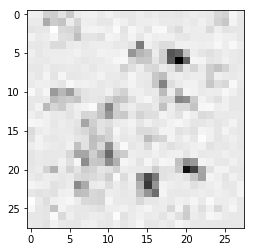

In [11]:
generated_image = sess.run(Gz,feed_dict={z_placeholder: z_batch})
generated_image = generated_image.reshape([batch_size,28, 28])
plt.imshow(generated_image[0], cmap='Greys')
plt.savefig("test_img.png")

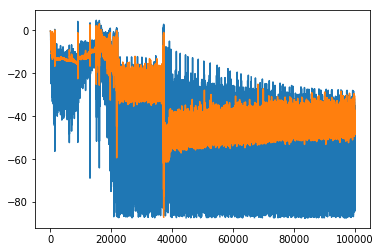

In [13]:
plt.plot(range(steps),np.log(Rresults),label = 'discriminator')
plt.plot(range(steps),np.log(Fresults),label = 'generator')